In [ ]:
!pip install scanpy

In [3]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import f1_score
from sklearn.base import clone
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
#import scanpy as sc
import pandas as pd

In [4]:
# Load the AnnData object from the HDF5 file
data = pd.read_csv("/kaggle/input/cell-type-determination-ml/transformeddata_onlyannotations.csv", index_col=0)
data


,4R79.1,AC3.10,AC3.12,AC3.2,AC3.5,AC3.7,AC8.11,AC8.4,AH6.1,AH6.14,...,linc043,linc090,linc093,linc095,linc109,linc118,linc128,linc136,linc148,linc168
1_P0_2_P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.321266,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.138373
1_P0_3_P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.225556,0.000000,0.0,0.0,0.0,0.0,0.000000,1.667956
1_P0_4_P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.375787,0.141539,0.141539,0.0,0.0,0.0,0.0,0.000000,1.469026
2_r1_1_AB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.285121,0.000000,0.0,0.0,0.0,0.0,0.285121,0.000000
2_r2_1_P1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.426616,0.000000,0.0,0.0,0.0,0.0,0.000000,1.999419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_r75_2_ABalpapx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.714560,0.0,0.0,0.0,0.0,0.000000,0.000000
96_r76_2_ABalaapx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000
96_r86_2_ABpxaaax,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.153326
96_r88_2_ABpxapax,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000


In [6]:
data["Classification"] = [l.split(sep="_")[-1] for l in data.index]

In [7]:
from sklearn.preprocessing import LabelEncoder

# Create a LabelEncoder object
encoder = LabelEncoder()

# Fit and transform the 'classification' column
data['Classification'] = encoder.fit_transform(data['Classification'])

# Print the updated 'classification' column
print(data['Classification'])


1_P0_2_P0            111
1_P0_3_P0            111
1_P0_4_P0            111
2_r1_1_AB              0
2_r2_1_P1            112
                    ... 
96_r75_2_ABalpapx     18
96_r76_2_ABalaapx      7
96_r86_2_ABpxaaax     49
96_r88_2_ABpxapax     54
96_r94_2_ABarpppx     42
Name: Classification, Length: 840, dtype: int64


### Transform the numerical encoded values back to original labels
original_labels = encoder.inverse_transform(data['classification'])

### Create a new column with the original labels
data['original_classification'] = original_labels

### Print the original classification column
print(data['original_classification'])

In [8]:
data

,4R79.1,AC3.10,AC3.12,AC3.2,AC3.5,AC3.7,AC8.11,AC8.4,AH6.1,AH6.14,...,linc090,linc093,linc095,linc109,linc118,linc128,linc136,linc148,linc168,Classification
1_P0_2_P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.321266,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.138373,111
1_P0_3_P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.225556,0.000000,0.0,0.0,0.0,0.0,0.000000,1.667956,111
1_P0_4_P0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.375787,0.141539,0.141539,0.0,0.0,0.0,0.0,0.000000,1.469026,111
2_r1_1_AB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.285121,0.000000,0.0,0.0,0.0,0.0,0.285121,0.000000,0
2_r2_1_P1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.426616,0.000000,0.0,0.0,0.0,0.0,0.000000,1.999419,112
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96_r75_2_ABalpapx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.714560,0.0,0.0,0.0,0.0,0.000000,0.000000,18
96_r76_2_ABalaapx,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,7
96_r86_2_ABpxaaax,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,1.153326,49
96_r88_2_ABpxapax,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,54


In [9]:
data = data.reset_index(drop=True)

X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["Classification"]), data["Classification"],
                                                    test_size=0.2, stratify=data["Classification"])



/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


   mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0       0.740259      0.010046         0.165813        0.009642     0.1   
1       0.704639      0.037479         0.173855        0.022107     0.8   
2       0.681095      0.054065         0.166068        0.015137       4   
3       0.688446      0.037501         0.161192        0.023860      10   
4       0.703568      0.051173         0.162292        0.021902      30   
5       0.722366      0.186372         0.146631        0.047853     100   

  param_kernel                          params  split0_test_score  \
0       linear  {'C': 0.1, 'kernel': 'linear'}           0.587561   
1       linear  {'C': 0.8, 'kernel': 'linear'}           0.587561   
2       linear    {'C': 4, 'kernel': 'linear'}           0.587561   
3       linear   {'C': 10, 'kernel': 'linear'}           0.587561   
4       linear   {'C': 30, 'kernel': 'linear'}           0.587561   
5       linear  {'C': 100, 'kernel': 'linear'}           0.5

/tmp/ipykernel_33/89092208.py:19: RuntimeWarning: invalid value encountered in divide
  cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


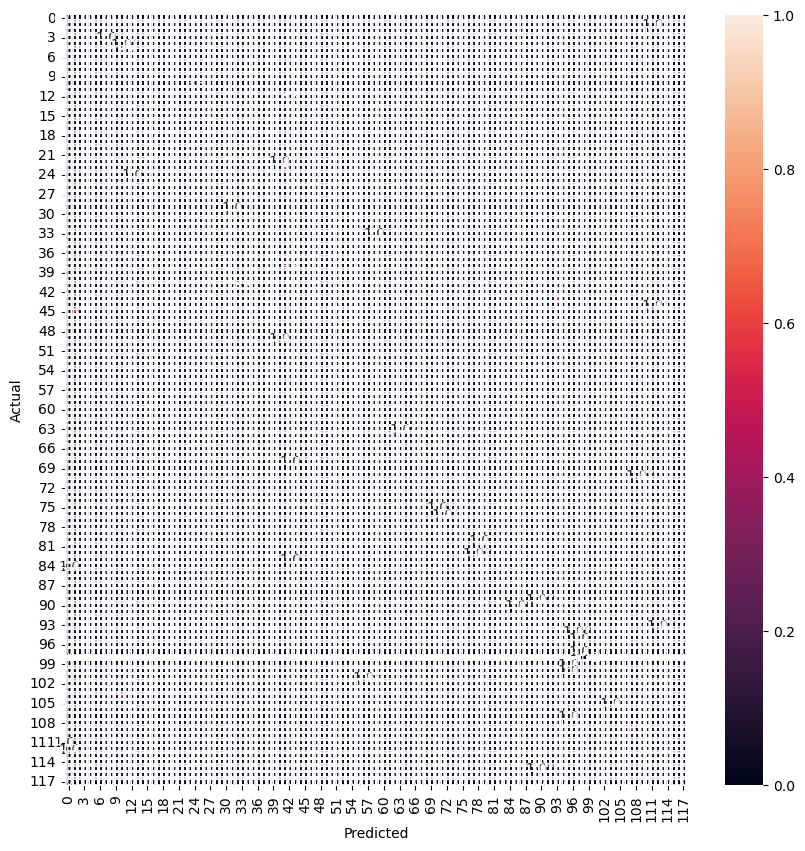

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2      21.362071      0.308551         0.309792        0.015257   
8      19.926958      1.562891         0.290658        0.047091   
5      13.233976      0.248138         0.260005        0.016925   
7       2.094141      0.022932         0.051985        0.000570   
1       2.109071      0.020190         0.056786        0.004306   
4       1.336184      0.025778         0.049649        0.003287   
0       0.247889      0.010786         0.030452        0.001409   
6       0.300675      0.046831         0.045106        0.017025   
3       0.170974      0.004160         0.029124        0.001622   

  param_max_depth param_n_estimators  \
2            None               1000   
8             100               1000   
5              10               1000   
7             100                100   
1            None                100   
4              10                100   
0            None                 10   
6        

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


   mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0       0.039439      0.002880         0.068069        0.021828   
1       0.040354      0.005263         0.065024        0.016707   
2       0.035569      0.000724         0.052032        0.000484   
3       0.039223      0.003966         0.053528        0.001100   
4       0.037432      0.003040         0.052851        0.007895   

  param_n_neighbors               params  split0_test_score  \
0                 1   {'n_neighbors': 1}           0.585185   
1                 5   {'n_neighbors': 5}           0.474074   
2                10  {'n_neighbors': 10}           0.451852   
3                20  {'n_neighbors': 20}           0.325926   
4                50  {'n_neighbors': 50}           0.229630   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
0           0.540741           0.529851           0.522388           0.589552   
1           0.481481           0.477612           0.4402

0.5714285714285714

In [10]:
def score(model, X, y):
    y_pred = model.predict(X)
    return f1_score(y, y_pred, average='macro')


# C = 100 is best
svc = GridSearchCV(SVC(), {"C": [0.1, 0.8, 4, 10, 30, 100],
                           "kernel": ["linear"]}, return_train_score=True,
                   n_jobs=-1, cv=5, scoring=score)
svc.fit(X_train, y_train)
res_svc = pd.DataFrame(svc.cv_results_).sort_values("rank_test_score")
print(res_svc)
cm = confusion_matrix(y_train, svc.best_estimator_.predict(X_train))
np.sum(np.diag(cm)) / np.sum(cm)
cm = confusion_matrix(y_test, svc.best_estimator_.predict(X_test))
np.sum(np.diag(cm)) / np.sum(cm)

# Normalise
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
np.fill_diagonal(cmn, 0)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cmn, annot=True, fmt='.2f')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)

# random forest

from sklearn.ensemble import RandomForestClassifier

rf = GridSearchCV(RandomForestClassifier(),
                  {"n_estimators": [10, 100, 1000], "max_depth": [None, 10, 100]}, n_jobs=-1, cv=5)
rf.fit(X_train, y_train)
res_rf = pd.DataFrame(rf.cv_results_).sort_values("rank_test_score")
print(res_rf)
cm = confusion_matrix(y_train, rf.best_estimator_.predict(X_train))
np.sum(np.diag(cm)) / np.sum(cm)
cm = confusion_matrix(y_test, rf.best_estimator_.predict(X_test))
np.sum(np.diag(cm)) / np.sum(cm)

# KNN

from sklearn.neighbors import KNeighborsClassifier

knn = GridSearchCV(KNeighborsClassifier(), {"n_neighbors": [1, 5, 10, 20, 50]}, n_jobs=-1, cv=5)
knn.fit(X_train, y_train)
res_knn = pd.DataFrame(knn.cv_results_).sort_values("rank_test_score")
print(res_knn)
cm = confusion_matrix(y_train, knn.best_estimator_.predict(X_train))
np.sum(np.diag(cm)) / np.sum(cm)
cm = confusion_matrix(y_test, knn.best_estimator_.predict(X_test))
np.sum(np.diag(cm)) / np.sum(cm)


In [63]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold

MLP = Pipeline([
    ("scale", StandardScaler()),
    ("MLP", MLPClassifier(hidden_layer_sizes=(100, 100, 100), alpha=0.01, max_iter=1000, activation='logistic', solver='lbfgs', learning_rate='adaptive'))
])

MLP.fit(X_train , y_train)

y_train_pred_MLP = MLP.predict(X_train)

print('MLP' , accuracy_score(y_train_pred_MLP , y_train))

MLP 0.9985119047619048


/opt/conda/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [64]:
y_test_pred_MLP = MLP.predict(X_test)

print('MLP' , accuracy_score(y_test_pred_MLP , y_test))

MLP 0.35714285714285715


param_grid = {
    "MLP__hidden_layer_sizes": [(5), (100,), (100, 100), (100, 100, 100)],
    "MLP__activation": ["relu", "logistic", "tanh"],
    'MLP__alpha': [0.001, 0.1, 0.01, 1],
    'MLP__max_iter': [1000]}
score = make_scorer(accuracy_score)  
model = GridSearchCV(MLP, [param_grid], 
                     n_jobs=-1, scoring=score, cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42))
model.fit(X_train, y_train)
pd.DataFrame(model.cv_results_).sort_values("rank_test_score").head()

In [72]:
param_grid = {
    "MLP__hidden_layer_sizes": [(5), (100,), (100, 100), (100, 100, 100)],
    "MLP__activation": ["relu", "logistic", "tanh"],
    'MLP__alpha': [0.001, 0.1, 0.01, 1],
    'MLP__max_iter': [1000]}

In [71]:
df = pd.read_csv('/kaggle/working/MLP_CV.csv')
df

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_MLP__activation,param_MLP__alpha,param_MLP__hidden_layer_sizes,param_MLP__max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,13,17.574634,1.700156,0.050030,0.000724,relu,1.00,"(100,)",1000,"{'MLP__activation': 'relu', 'MLP__alpha': 1, '...",0.437037,0.437037,0.507463,0.440299,0.462687,0.456904,0.027036,1
1,5,5.701376,0.884722,0.055870,0.006601,relu,0.10,"(100,)",1000,"{'MLP__activation': 'relu', 'MLP__alpha': 0.1,...",0.437037,0.437037,0.492537,0.388060,0.395522,0.430039,0.037303,2
2,29,13.842862,0.674324,0.049882,0.002270,logistic,1.00,"(100,)",1000,"{'MLP__activation': 'logistic', 'MLP__alpha': ...",0.392593,0.422222,0.500000,0.350746,0.440299,0.421172,0.049714,3
3,25,3.230596,0.126508,0.050319,0.002556,logistic,0.01,"(100,)",1000,"{'MLP__activation': 'logistic', 'MLP__alpha': ...",0.407407,0.400000,0.447761,0.380597,0.402985,0.407750,0.022005,4
4,21,3.892652,0.316016,0.047534,0.000593,logistic,0.10,"(100,)",1000,"{'MLP__activation': 'logistic', 'MLP__alpha': ...",0.437037,0.355556,0.447761,0.373134,0.417910,0.406280,0.035982,5


In [1]:
df = pd.read_csv('/kaggle/working/MLP_CV.csv')

NameError: name 'pd' is not defined

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras

N_EPOCHS = 1000
N_CELLTYPES = 119


def label_encoder(data):
    labelenc = LabelEncoder()
    labelenc.fit(data["Annotated State"])
    return labelenc


def main():
    #X_test, X_train, y_test, y_train = make_train_and_test_sets()


    model1 = keras.models.Sequential([
        keras.layers.Dense(600, activation="tanh"),
        keras.layers.Dense(800, activation="tanh"),
        keras.layers.Dense(N_CELLTYPES, activation="softmax")
    ])
    model2act = "tanh"
    model2 = keras.models.Sequential([
        keras.layers.Dense(500, activation=model2act),
        keras.layers.Dense(400, activation=model2act),
        keras.layers.Dense(300, activation=model2act),
        keras.layers.Dense(200, activation=model2act),
        keras.layers.Dense(N_CELLTYPES, activation="softmax")
    ])
    model3act = "relu"
    inputs = keras.Input(shape=(2000,))
    query_layer = keras.layers.Dense(400, activation=model3act)(inputs)
    query_layer = keras.layers.Reshape((20, 20))(query_layer)
    value_layer = keras.layers.Dense(400, activation=model3act)(inputs)
    value_layer = keras.layers.Reshape((20, 20))(value_layer)
    key_layer = keras.layers.Dense(400, activation=model3act)(inputs)
    key_layer = keras.layers.Reshape((20, 20))(key_layer)
    att_layer = keras.layers.MultiHeadAttention(num_heads=2, key_dim=20)(query=query_layer,
                                                                        value=value_layer,
                                                                         key=key_layer)
    denselayer = keras.layers.Dense(300, activation=model3act)(keras.layers.Flatten()(att_layer))
    softmax_layer = keras.layers.Softmax()(denselayer)
    model3 = keras.Model(inputs=inputs, outputs=softmax_layer, name="test")
    print(model3.summary())
    print(X_test)
    train_and_evaluate(X_test, X_train, model2, y_test, y_train, optimizer="sgd")


def train_and_evaluate(X_test, X_train, model, y_test, y_train, optimizer="sgd"):
    keras.backend.clear_session()
    np.random.seed(42)
    tf.random.set_seed(42)
    model.compile(loss="sparse_categorical_crossentropy",
                  optimizer=optimizer,
                  metrics=["accuracy"])
    history = model.fit(X_train, y_train, epochs=N_EPOCHS,
                        validation_data=(X_test, y_test))
    plot_history(history)
    classified = np.argmax(model.predict(X_test), axis=1)
    cm = confusion_matrix(y_true=y_test, y_pred=classified, labels = list(range(N_CELLTYPES)))

    # viz of data availability
    availability_plot(cm, y_test, y_train)

    often_confused = calculate_often_confused(cm)
    print("Often confused: ", often_confused)

    print(np.sum(np.diag(cm)) / np.sum(cm))


def calculate_often_confused(cm):
    often_confused = [(i, j, cm[i, j] + cm[j, i]) for (i, j) in itertools.product(range(N_CELLTYPES), repeat=2)
                      if i < j and cm[i, j] + cm[j, i] >= 2]
    return often_confused


def availability_plot(cm, y_test, y_train):
    celltypes_count_in_train = np.array([np.count_nonzero(y_train == i) for i in range(N_CELLTYPES)])
    celltypes_count_in_test = [np.count_nonzero(y_test == i) for i in range(N_CELLTYPES)]
    correct = np.diag(cm)

    def precision_by_noccurence(i):
        sum_of_correct = sum(correct[celltypes_count_in_train == i])
        sum_of_all = np.sum(cm[celltypes_count_in_train == i, :])
        if sum_of_all == 0:
            return -0.1
        return sum_of_correct / sum_of_all

    def recall_by_noccurence(i):
        sum_of_correct = sum(correct[celltypes_count_in_train == i])
        sum_of_all = np.sum(cm[:, celltypes_count_in_train == i])
        if sum_of_all == 0:
            return -0.1
        return sum_of_correct / sum_of_all

    prec_by_noccurance = np.array([precision_by_noccurence(i) for i in range(2, 17)])
    # plt.scatter(celltypes_count_in_train, correct)
    # plt.show()
    plt.bar(range(2, 17), prec_by_noccurance)
    plt.show()
    rec_by_noccurance = np.array([recall_by_noccurence(i) for i in range(2, 17)])
    # plt.scatter(celltypes_count_in_train, correct)
    # plt.show()
    plt.bar(range(2, 17), rec_by_noccurance)
    plt.show()

def plot_history(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()


def make_train_and_test_sets():
    data = pd.read_csv("/kaggle/input/cell-type-determination-ml/transformeddata_onlyannotations.csv", index_col=0)
    #data = pd.read_csv("out/diffmap_ztransform_cellid.csv", index_col=0)
    data["Annotated State"] = [l.split(sep="_")[-1] for l in data.index]
    X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=["Annotated State"]), data["Annotated State"],
                                                        test_size=0.2, stratify=data["Annotated State"])
    labelenc = label_encoder(data)
    y_train = labelenc.transform(y_train)
    y_test = labelenc.transform(y_test)
    return X_test, X_train, y_test, y_train


if __name__ == '__main__':
    main()

Model: "test"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 2000)]       0           []                               
                                                                                                  
 dense_8 (Dense)                (None, 400)          800400      ['input_1[0][0]']                
                                                                                                  
 dense_10 (Dense)               (None, 400)          800400      ['input_1[0][0]']                
                                                                                                  
 dense_9 (Dense)                (None, 400)          800400      ['input_1[0][0]']                
                                                                                               

In [92]:
row_indices = [5, 12, 87, 91, 2]  # Replace with the row indices you want to retrieve
selected_rows = data.iloc[row_indices]
selected_rows

,AC3.2,AH6.5,B0213.6,B0222.9,B0252.2,B0252.3,B0272.4,B0280.5,B0303.8,B0304.1,...,ZK185.3,ZK228.3,ZK328.8,ZK550.6,ZK637.11,ZK858.3,ZK899.6,ZK930.3,ZK993.1,Classification
5,0.000000,3.859388,0.0,0.0,0.000000,0.000000,0.0,2.657986,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.471920,3.095913,0.000000,0.0,0.0,112
12,0.000000,4.170616,0.0,0.0,0.764884,0.453857,0.0,0.764884,0.0,0.0,...,0.0,0.0,0.000000,0.0,2.263385,3.372257,0.000000,0.0,0.0,1
87,0.415927,1.160662,0.0,0.0,0.000000,0.000000,0.0,0.327022,0.0,0.0,...,0.0,0.0,0.000000,0.0,1.972594,3.947465,3.545423,0.0,0.0,13
91,0.560138,1.505025,0.0,0.0,0.000000,0.000000,0.0,0.693757,0.0,0.0,...,0.0,0.0,0.405871,0.0,1.982052,3.952439,3.451168,0.0,0.0,2
2,0.000000,4.186185,0.0,0.0,0.265506,0.000000,0.0,4.124198,0.0,0.0,...,0.0,0.0,0.000000,0.0,1.794672,2.916973,0.000000,0.0,0.0,111


In [34]:
from sklearn.metrics import make_scorer, accuracy_score

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Create a logistic regression classifier
logreg = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],
    'solver': ['newton-cg', 'lbfgs', 'saga'],
    'max_iter': [1000],
    'multi_class': ['multinomial'],
    'n_jobs': [-1]
}

# Define the scoring metric
scorer = make_scorer(accuracy_score)

# Perform grid search cross-validation
model = GridSearchCV(logreg, param_grid, scoring=scorer, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), n_jobs=-1)
model.fit(X_train, y_train)

# Get the results as a DataFrame
results = pd.DataFrame(model.cv_results_).sort_values("rank_test_score")

# Display the top performing hyperparameter settings
top_results = results.head()
print(top_results)

/opt/conda/lib/python3.10/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs fail

    mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
14    2054.006649     15.417199         0.042542        0.002079   
8     1040.456424      6.839904         0.045638        0.005207   
2      223.330734      3.838260         0.043883        0.001773   
11     753.930803      2.928963         0.041293        0.001588   
17     954.511191    226.711201         0.037911        0.005169   

   param_max_iter param_multi_class param_n_jobs param_penalty param_solver  \
14           1000       multinomial           -1            l1         saga   
8             500       multinomial           -1            l1         saga   
2             100       multinomial           -1            l1         saga   
11            500       multinomial           -1            l2         saga   
17           1000       multinomial           -1            l2         saga   

                                               params  split0_test_score  \
14  {'max_iter': 1000, 'multi_class': 'm

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [116]:
# Get the best model with the best parameters
best_model = model.best_estimator_

# Fit the best model on the training data
best_model.fit(X_train, y_train)


# Predict using the best model on the test data
y_pred = best_model.predict(X_test)


# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

AttributeError: 'Sequential' object has no attribute 'best_estimator_'

Accuracy: 0.6904761904761905


In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import StratifiedKFold

best_params = {'max_iter': 1000,
 'multi_class': 'multinomial',
 'n_jobs': -1,
 'penalty': 'l1',
 'solver': 'saga'}

# Create a logistic regression classifier with the best parameters
best_model = LogisticRegression(**best_params)

# Fit the best model on the training data
best_model.fit(X_train, y_train)

# Predict using the best model on the test data
y_pred = best_model.predict(X_test)

# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

KeyboardInterrupt: 

In [24]:
from sklearn import metrics
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [85]:
%%time

# Default
#clf = LogisticRegression(penalty='l2', solver="lbfgs", max_iter=100, n_jobs=-1)

# Optimal
clf = LogisticRegression(random_state=123456, penalty='l2', solver="newton-cg", max_iter=100, multi_class="multinomial", n_jobs=-1)

clf.fit(X_train, y_train)

CPU times: user 46.6 ms, sys: 128 ms, total: 175 ms
Wall time: 9.46 s


LogisticRegression(multi_class='multinomial', n_jobs=-1, random_state=123456,
                   solver='newton-cg')

In [79]:
# Run this to predict on training set
y_pred = clf.predict(X_train)
#pred_df = pd.DataFrame(y_pred)
#pred_df.to_csv("./lr_multi_optimal_training_cov_3.5_pred.csv")
cm = pd.DataFrame(metrics.confusion_matrix(y_train, y_pred))
print("Cohen's Kappa: ", metrics.cohen_kappa_score(y_train, y_pred))

Cohen's Kappa:  1.0


In [86]:
# Run this to predict on testing set
y_pred = clf.predict(X_test)
cm = pd.DataFrame(metrics.confusion_matrix(y_test, y_pred))
print("Cohen's Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

Cohen's Kappa:  0.6750716332378224
